# Proyectando el comportamiento de la soja

_Competencia Metadata 2019_  
_https://metadata.fundacionsadosky.org.ar/competition/11/_

## Objetivos
1. Lograr el mejor fit para la serie de retornos simples diarios $\frac{p_1 - p_0}{p_0}$. Serie desde la Fecha de Cierre del Concurso (FCC 29/9/2019) + 10 días hábiles.
2. Lograr la mejor proyección para el último valor de la serie contínua de la soja al fin del concurso. Cierra a la FCC + 10 días hábiles.
3. Lograr el mejor fit para la serie de retornos simples diarios de 4 semanas. Desde FCC - 10 días hábiles, hasta FCC + 10 días hábiles.

## Dataset oficial

[Dataset](https://drive.google.com/file/d/1r0DWiUIQ_N13HeervqrUhbV3TjUlEe4Q/view?usp=sharing) la información que contiene este archivo es hasta el día 29/8/2019. Por ende para calcular el score circunstancial se entiende que usted está proyectando hasta el día 12/9/2019. Esta información se irá actualizando todas las semanas hasta la última actualización que será el día 27/9/2019.

## Descripción

- `Fecha` Fecha de referencia para el precio.
- `Open` Precio de apertura del día.
- `High` Precio máximo del día.
- `Low` Precio mínimo del día.
- `Last` Precio último operado del día.
- `Cierre` Precio de ajuste del día. **Ésta es la serie a proyectarse.**
- `Aj.Dif.` Diferencia nominal respecto del día anterior.
- `Mon` Moneda de denominación del contrato.
- `Oi.Vol` Interés abierto del contrato.
- `Oi.Dif.` Diferencia del interés abierto respecto del día anterior.
- `Vol.Ope.` Volumen Operado medido en contratos.
- `Unidad` Unidad en que se miden los contratos.
- `DolarB.N.` Precio del dólar del Banco de la Nación Argentina.
- `DolarItau` Precio del dólar del Banco Itaú.
- `Diff.Sem` Diferencia Semanal.

## Métrica

La calificación de la solución propuesta se hace con el error absoluto medio ([MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) por su sigla en inglés) y se calcula como el promedio de las diferencias (en valor absoluto) entre las respuestas enviadas y las correctas:

$$ MAE = \frac{1}{n} \sum_{j=1}^{n} |y_j - \hat{y_j} | $$

## Formato de respuesta

Debe enviarse un archivo en formato `csv` sin encabezado con 4 columnas y 20 filas.

- Primer columna debe contener al número de fila (int).
- Segunda columna debe contener las fechas correspondientes en formato "dd/mm/YYYY."
- Tercer columna debe contener los retornos (float).
- Cuarta columna debe contener el precio (cierre del día) del contrato (float).

Las filas 1 a 10 corresponden a FCC - 10 días hábiles y las filas 11 a 20 corresponden a la proyección futura.

## Exploración

In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import pyflux as pf
import seaborn as sns
import statsmodels.api as sm

warnings.simplefilter('ignore')
register_matplotlib_converters()

In [2]:
sns.set(rc={'figure.figsize': (12,8)})

In [3]:
data_dir = 'data/'

In [4]:
date_parser = lambda x: pd.datetime.strptime(x, "%d/%m/%Y 12:00:00 a.m.")
df = pd.read_csv(os.path.join(data_dir, 'datasetRofex2.csv'),
                 parse_dates=['Fecha'],
                 index_col='Fecha',
                 date_parser=date_parser)

In [5]:
df.head()

,Id,Open,High,Low,Last,Cierre,Aj.Dif.,Mon.,OI.Vol.,OI.Dif.,Vol.Ope.,Unidad,DolarB.N.,DolarItau.,Dif.Sem
Fecha,,,,,,,,,,,,,,,
2004-01-05,1,0.0,0.0,0.0,0.0,221.0,13.0,D,0.0,0.0,0,TONS,2.920,2.905,-221.0
2004-01-06,2,0.0,0.0,0.0,0.0,221.0,0.0,D,0.0,0.0,0,TONS,2.880,2.870,-221.0
2004-01-07,3,0.0,0.0,0.0,0.0,219.0,-2.0,D,0.0,0.0,0,TONS,2.865,2.882,-219.0
2004-01-08,4,0.0,0.0,0.0,0.0,220.0,1.0,D,0.0,0.0,0,TONS,2.887,2.884,-220.0
2004-01-09,5,0.0,0.0,0.0,0.0,220.0,0.0,D,0.0,0.0,0,TONS,2.892,2.900,-220.0


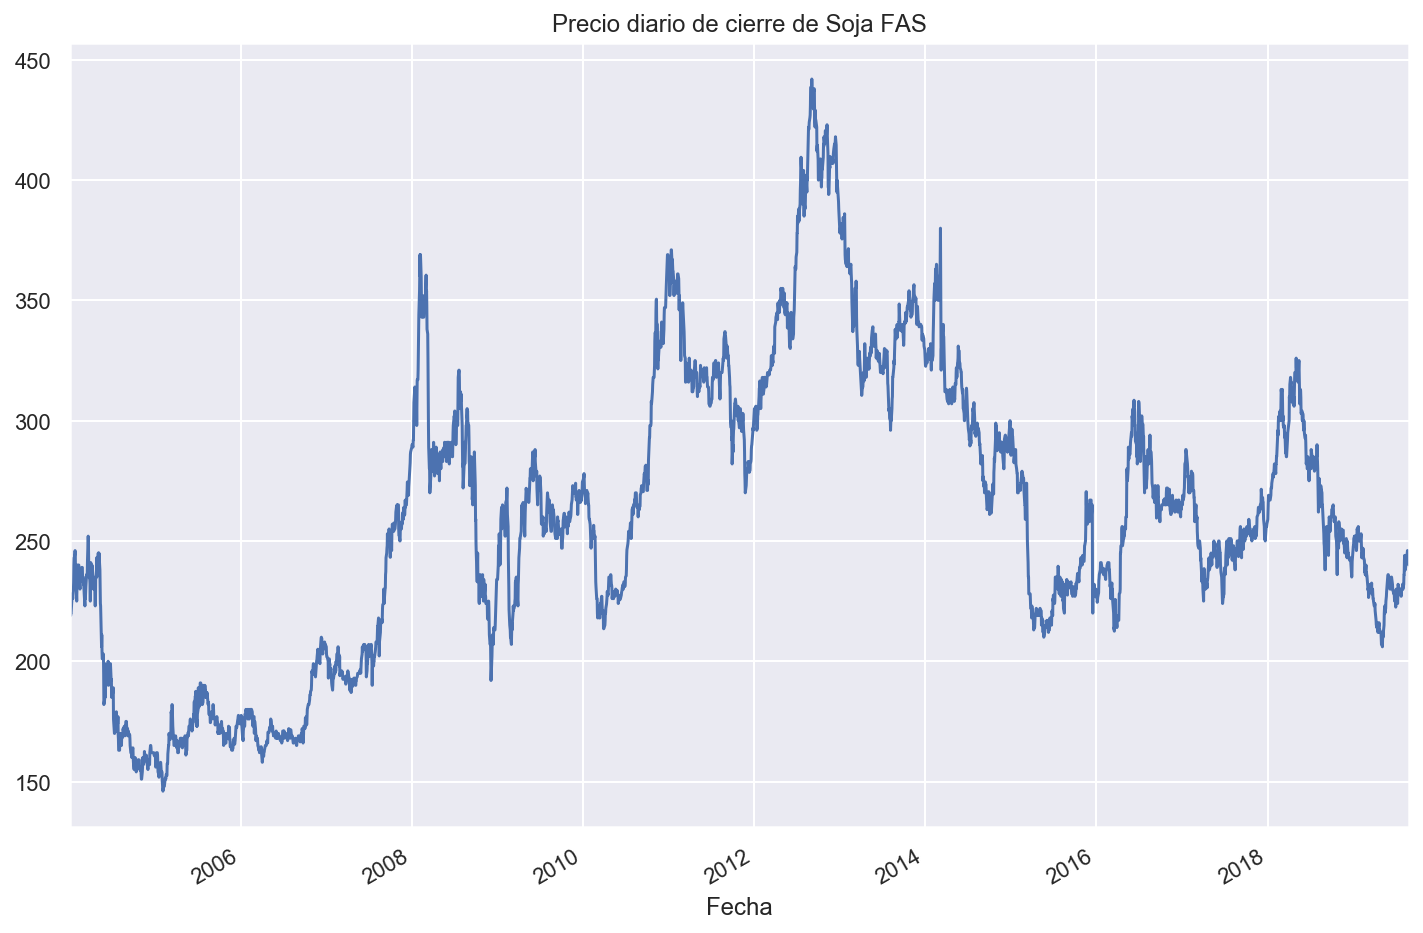

In [6]:
df['Cierre'].plot(title='Precio diario de cierre de Soja FAS');

In [7]:
df['retorno'] = df['Cierre'].pct_change()

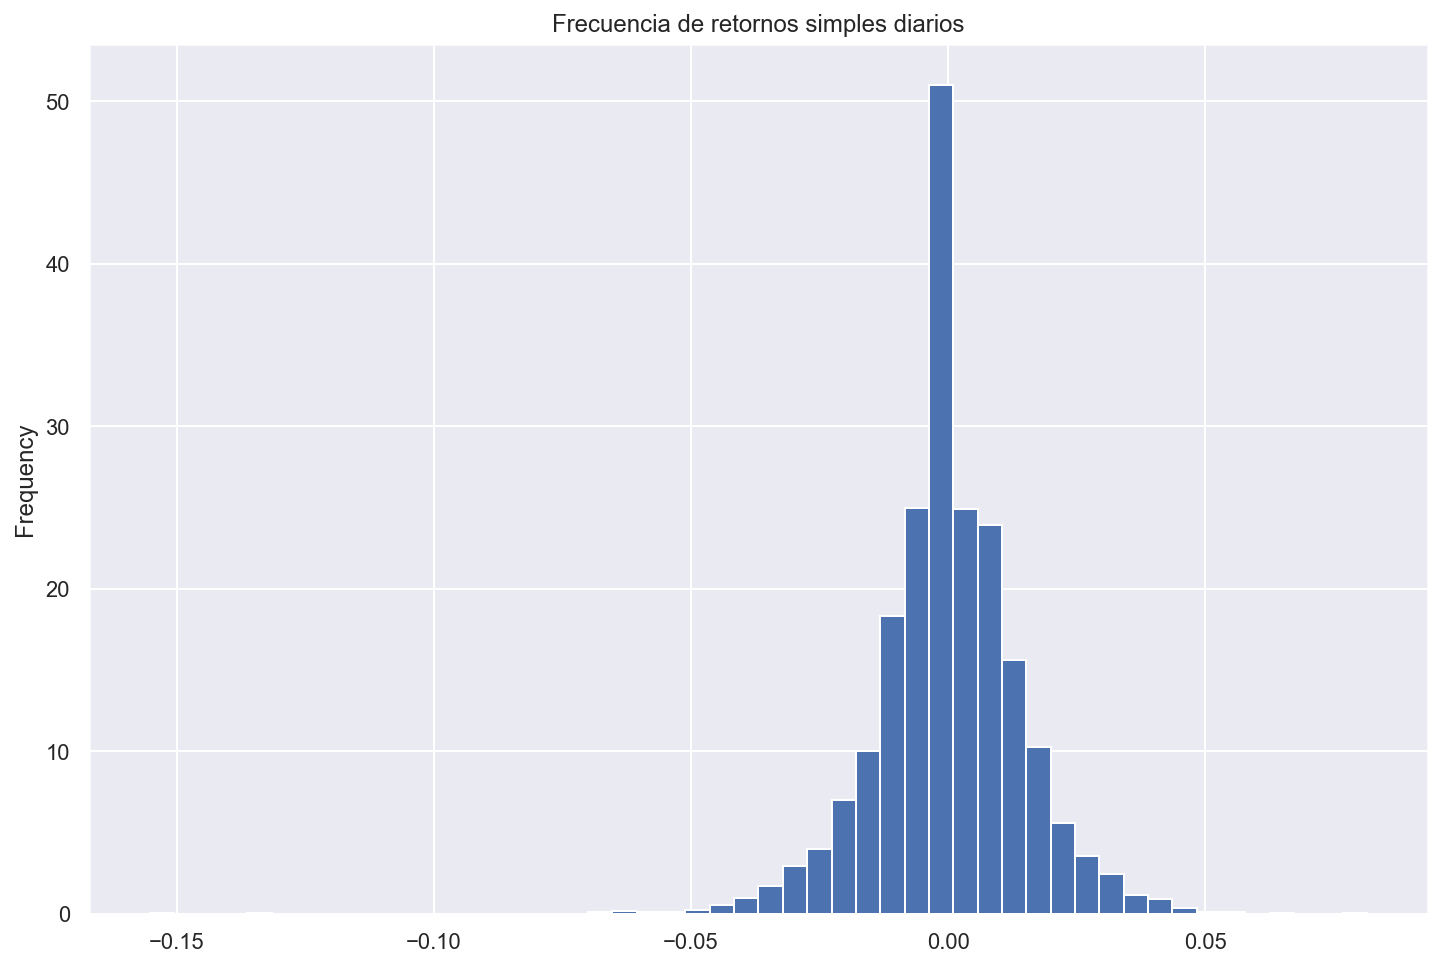

In [8]:
df['retorno'].plot(kind='hist', bins=50, title='Frecuencia de retornos simples diarios', density=True);

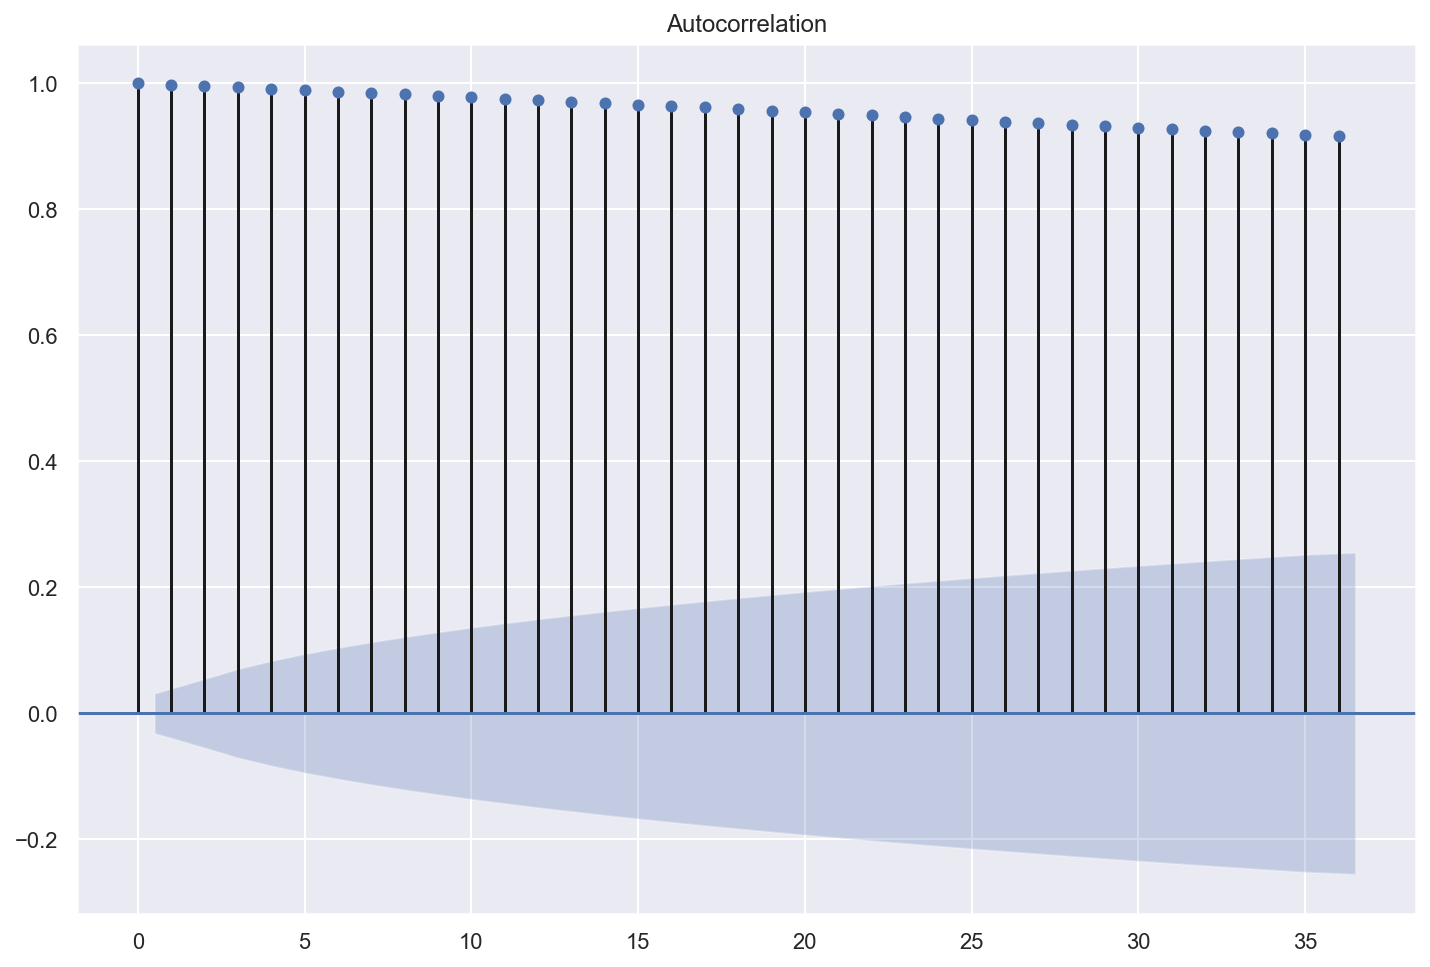

In [9]:
sm.graphics.tsa.plot_acf(df['Cierre']);

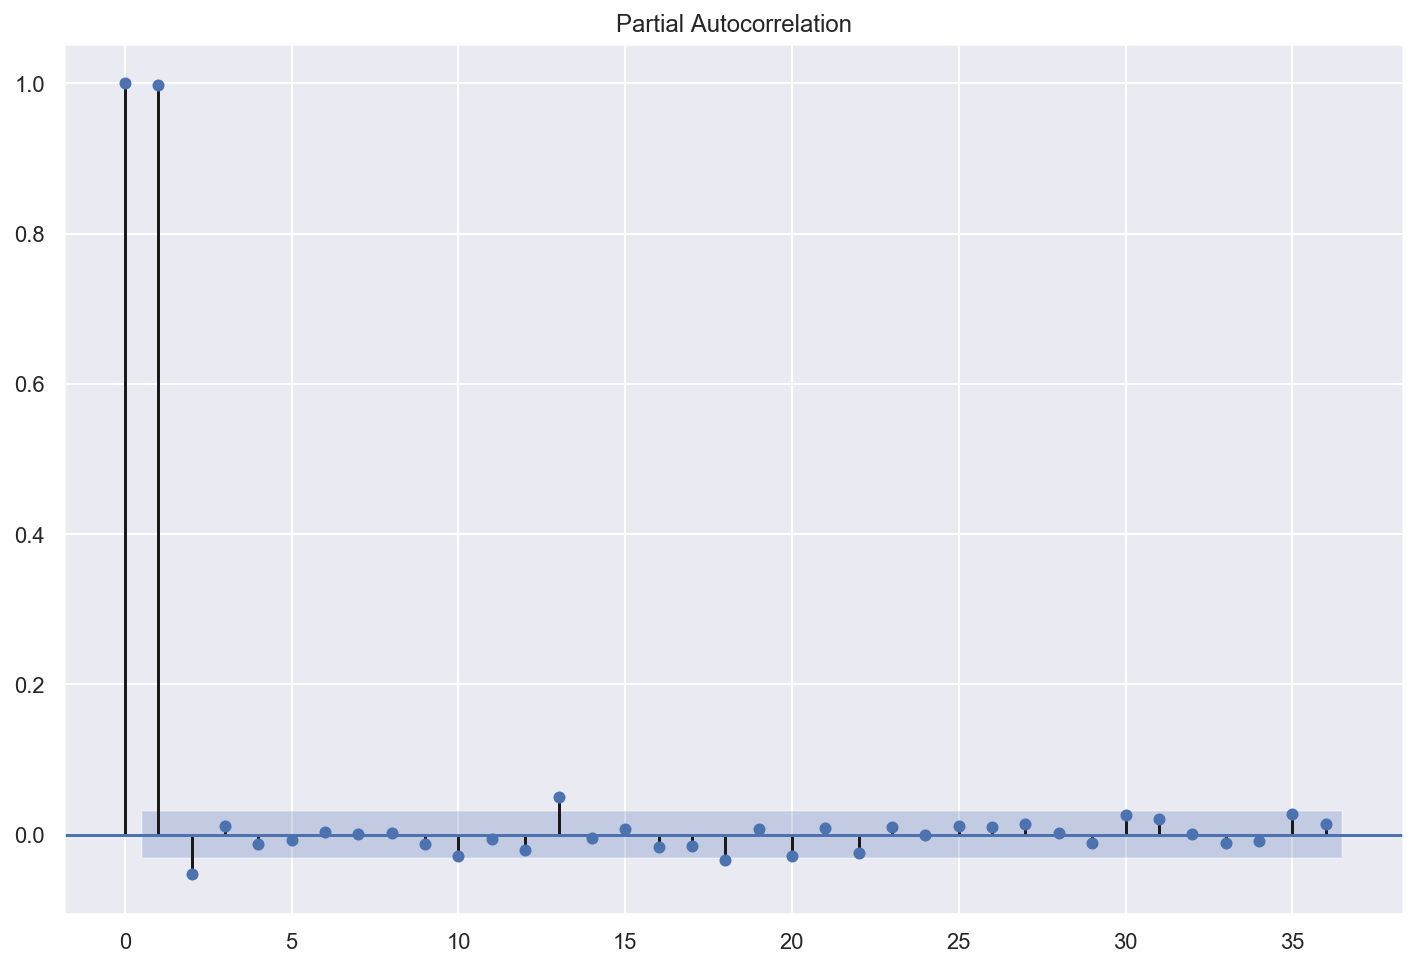

In [10]:
sm.graphics.tsa.plot_pacf(df['Cierre']);

In [11]:
model = pf.ARIMA(data=df, target='Cierre', ar=2, ma=0, family=pf.Normal())

In [12]:
print(model.latent_variables)

Index    Latent Variable           Prior           Prior Hyperparameters     V.I. Dist  Transform 
======== ========================= =============== ========================= ========== ==========
0        Constant                  Normal          mu0: 0, sigma0: 3         Normal     None      
1        AR(1)                     Normal          mu0: 0, sigma0: 0.5       Normal     None      
2        AR(2)                     Normal          mu0: 0, sigma0: 0.5       Normal     None      
3        Normal Scale              Flat            n/a (non-informative)     Normal     exp       


In [13]:
fit = model.fit('M-H')

Acceptance rate of Metropolis-Hastings is 0.006
Acceptance rate of Metropolis-Hastings is 0.1101
Acceptance rate of Metropolis-Hastings is 0.1338
Acceptance rate of Metropolis-Hastings is 0.1732
Acceptance rate of Metropolis-Hastings is 0.2327
Acceptance rate of Metropolis-Hastings is 0.2886

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.2867


In [14]:
fit.summary()

Normal ARIMA(2,0,0)                                                                                       
======================================================= ==================================================
Dependent Variable: Cierre                              Method: Metropolis Hastings                       
Start Date: 2004-01-07 00:00:00                         Unnormalized Log Posterior: -10601.435            
End Date: 2019-08-29 00:00:00                           AIC: 21210.87003901516                            
Number of observations: 3852                            BIC: 21235.895430106833                           
Latent Variable                          Median             Mean               95% Credibility Interval 
======================================== ================== ================== =========================
Constant                                 0.3378             0.388              (0.0826 | 0.7633)        
AR(1)                                    1.

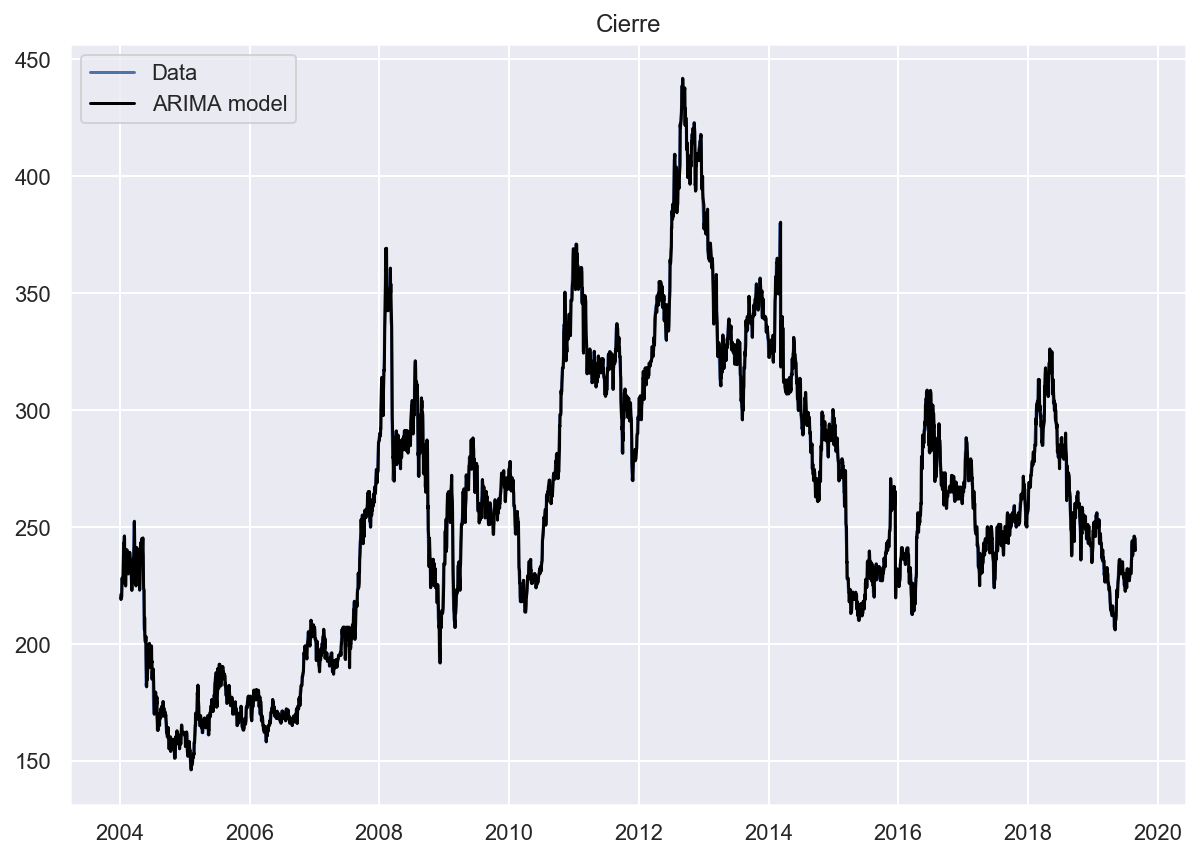

In [15]:
model.plot_fit()

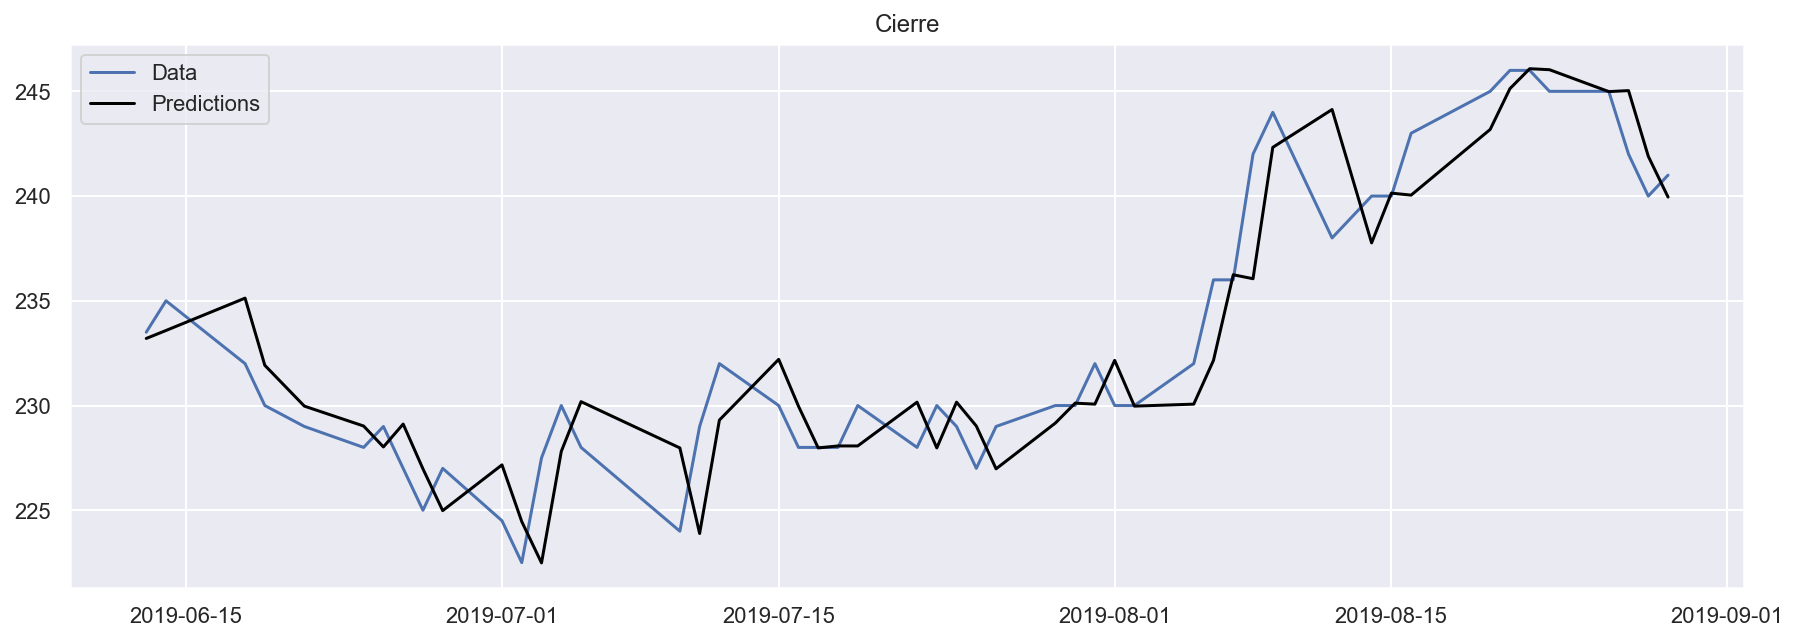

In [16]:
model.plot_predict_is(h=50, figsize=(15,5))

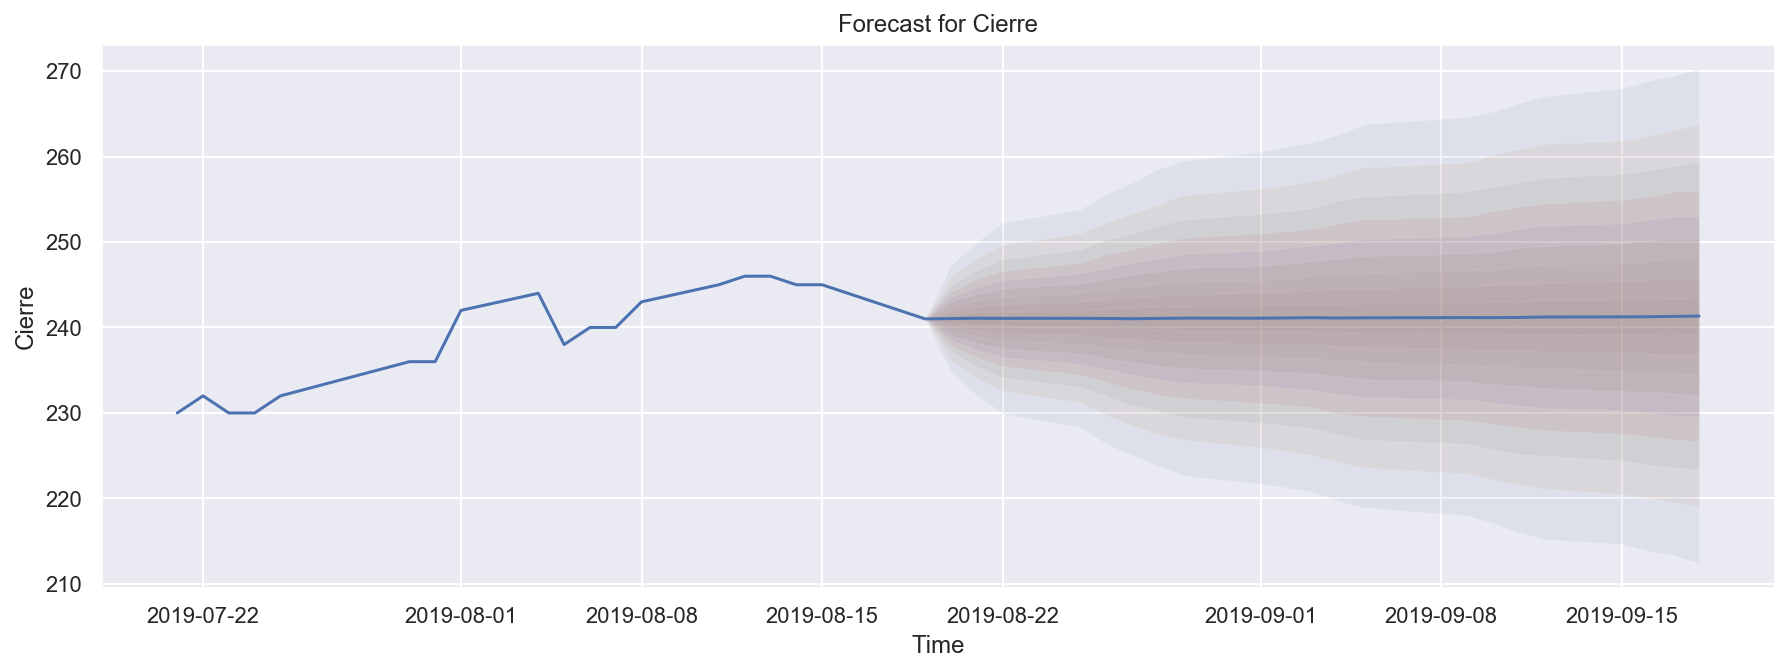

In [17]:
model.plot_predict(h=20,past_values=20,figsize=(15,5))

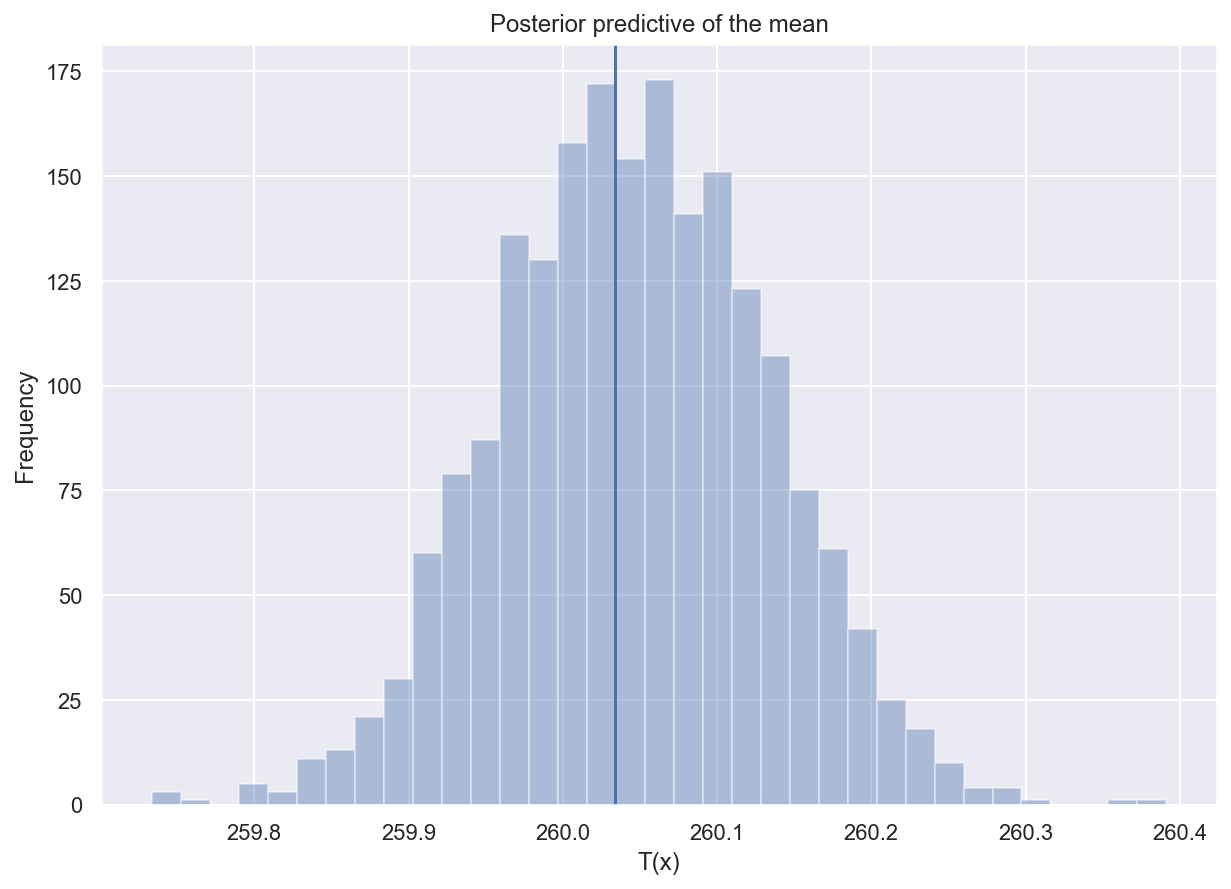

In [18]:
model.plot_ppc(T=np.mean, nsims=2000)

In [19]:
# Workaround for pyflux `plot_z()` method

from scipy.stats import norm
from matplotlib import mlab

mlab.normpdf = norm.pdf

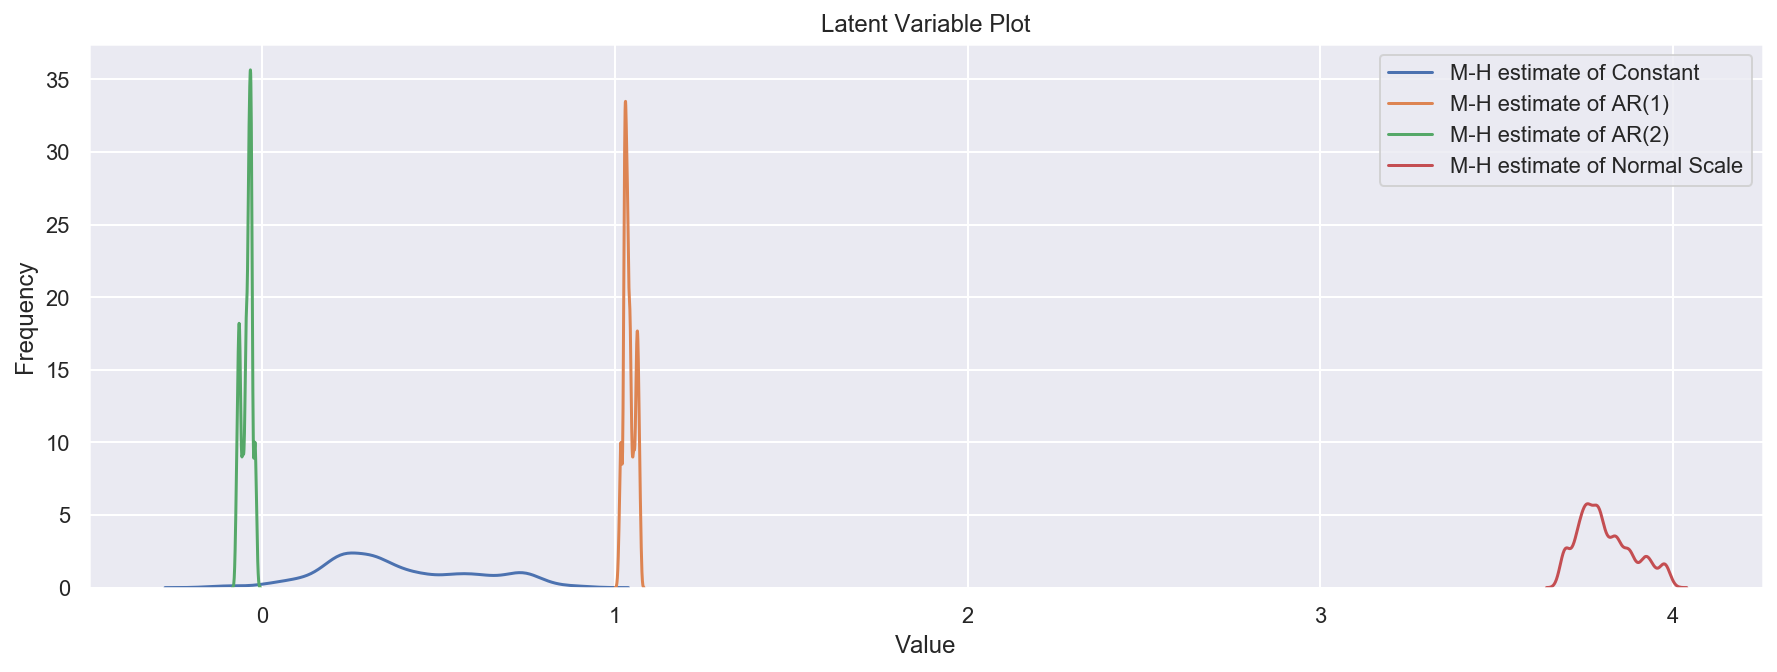

In [20]:
model.plot_z()